In [13]:
import numpy as np
import pandas as pd
import dicom
import os
import matplotlib.pyplot as plt
import cv2
import math
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

data_dir = 'F:/Minor Project 2/input'
patients = os.listdir(data_dir)
patients.sort()
labels = pd.read_csv('F:/Minor Project 2/input/stage1_labels.csv', index_col = 0)


C:\Anaconda\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [14]:
# Outputing the data to see the structure , 1 means that patient has cancer and 0 means he doesnot
labels.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [15]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    # loading the scans of the patients
    #Below is code to load a scan, which consists of multiple slices, 
    #which we simply save in a Python list. Every folder in the dataset is 
    #one scan (so one patient).
    #One metadata field is missing, the pixel size in the Z direction,
    #which is the slice thickness.
    #Fortunately we can infer this, and we add this to the metadata.
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices


In [16]:
def get_pixels_hu(slices):
    #getting the Hounsfield Units
    image = np.stack([s.pixel_array for s in slices])
    #Convert to int 16
    image = image.astype(np.int16)
    
    #Setting outside the scan pixels to 0
    # The intercept is usually - 1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Converting to Hounsfield usnits
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)


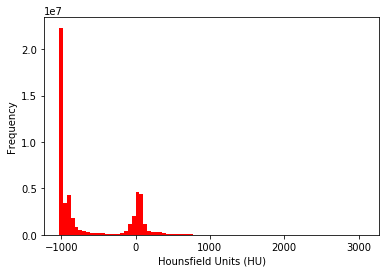

In [17]:
# Taking look at one of the patients
random_patient = load_scan(data_dir +'/'+ patients[0])
random_patient_pixels = get_pixels_hu(random_patient)
plt.hist(random_patient_pixels.flatten(), bins=80, color='r')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

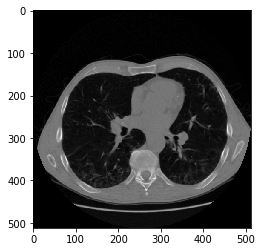

In [18]:
# Show some slice in the middle
plt.imshow(random_patient_pixels[100], cmap=plt.cm.gray)
plt.show()

In [19]:
def resample(image,scan,new_spacing = [1,1,1]):
    #changin the dimension to 1mm X 1mm X 1mm
    #determining the current pixel spacing 
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype = np.float32)
    
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image,real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [20]:
#for visualizing purposes we need the 3d plot of the lung
def plot_3d(image, threshold = -300):
    #Positioning the scan upright
    p = image.transpose(2,1,0)
    
    verts,faces = measure.marching_cubes_classic(p,threshold)
    
    fig = plt.figure(figsize= (10,10))
    ax = fig.add_subplot(111, projection = '3d')
    
    mesh = Poly3DCollection(verts[faces], alpha= 0.70)
    face_color = [0.45,0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2]) 
    
    plt.show()
#400 is a good threshold for showing the bones only

In [21]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [22]:
def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [23]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [24]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [25]:
pix_resampled, spacing = resample(random_patient_pixels, random_patient, [1,1,1])
print("Shape before resampling\t", random_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (195, 512, 512)
Shape after resampling	 (390, 355, 355)


In [26]:
plot_3d(pix_resampled, 400)

KeyboardInterrupt: 

In [27]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

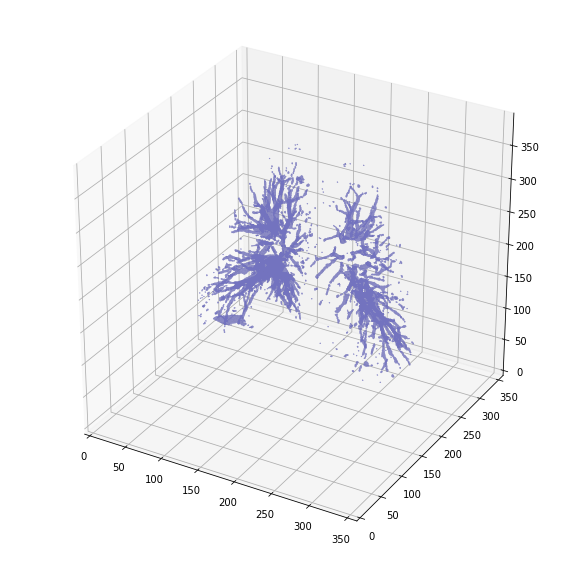

In [28]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [11]:
len(patients)

NameError: name 'patients' is not defined

In [12]:
len(labels)
   

NameError: name 'labels' is not defined